In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
import sklearn

### In this analysis I use pipelines to check the best classification algorithms, scalers and imputer strategies before the best algorithm or ensemble algorithm training step.

In [243]:
titanic = pd.read_csv("titanic_train.csv").drop(columns = ["PassengerId", "Ticket"])
titanic

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C148,C


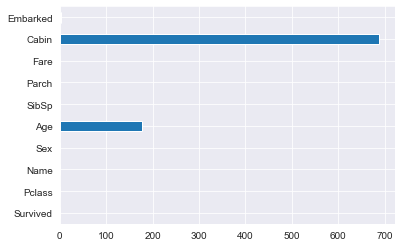

In [244]:
titanic.isna().sum().plot(kind = "barh")

In [245]:
pd.DataFrame(titanic.isna().sum()).T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,0,0,0,177,0,0,0,687,2


### Cabin variable has almost all nulls so I remove them from dataset. After removing this variable only Age and Embarked have nulls. Due to only two nulls in Embarked variable I replace them by mode. In further analysis I use SimpleImputer to Age variable and check which strategy (mean, median, constant or most frequent) is better.

In [246]:
titanic.drop(columns = "Cabin", inplace = True)
titanic = titanic.assign(Embarked = np.where(titanic.Embarked.isna(), titanic.Embarked.mode(), titanic.Embarked))

In [247]:
titanic["Salutation"] = titanic.Name.str.extract(pat = "([A-Z][a-z]*\\.)")
titanic.drop(columns = "Name", inplace = True)

In [413]:
(titanic.groupby(["Salutation"]).agg(surv_rate = ("Survived", "mean"),
                                    n = ("Survived", "count")).reset_index().
sort_values(by = "surv_rate"))

,Salutation,surv_rate,n
0,Capt.,0.000000,1
3,Don.,0.000000,1
5,Jonkheer.,0.000000,1
15,Rev.,0.000000,6
12,Mr.,0.156673,517
4,Dr.,0.428571,7
1,Col.,0.500000,2
7,Major.,0.500000,2
8,Master.,0.575000,40
9,Miss.,0.697802,182


### I combine salutation types with small number of observations in one called "Others".

In [419]:
titanic["Salutation"] = np.where(np.isin(titanic.Salutation, ["Mr.", "Master", "Miss.", "Mrs."]), titanic.Salutation, "Others")

In [420]:
(titanic.groupby(["Salutation"]).agg(surv_rate = ("Survived", "mean"),
                                    n = ("Survived", "count")).reset_index().
sort_values(by = "surv_rate"))

,Salutation,surv_rate,n
1,Mr.,0.156673,517
3,Others,0.522388,67
0,Miss.,0.697802,182
2,Mrs.,0.792000,125


In [421]:
titanic.dtypes

Survived        int64
Pclass          int64
Sex            object
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Salutation     object
dtype: object

### Titanic dataset contain numerical and categorical variables so in my main pipeline i have to include minor categorical and numerical pipelines. First I split dataset into test and train. 

In [422]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(titanic.drop(columns = "Survived"), titanic.Survived, 
                                                    test_size = 0.3, random_state = 42)

In [423]:
numerical_features = X_train.select_dtypes(exclude = "object").columns
categorical_features = X_train.select_dtypes(include = "object").columns

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Categorical features: Index(['Sex', 'Embarked', 'Salutation'], dtype='object')


In [424]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numerical_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean")),
    ("scaler", StandardScaler())
])

In [425]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps = [
    ("encoder", OneHotEncoder(handle_unknown = "ignore"))
])

### In below step I combine little pipelines into bigger one.

In [426]:
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers = [
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)
])

### Here I add to this pipeline logistic regression algorithm and that's it. Simple machine learning pipeline is created.

In [428]:
from sklearn.linear_model import LogisticRegression

classifier = Pipeline(steps = [
    ("data_transformer", transformer),
    ("ml_alg", DummyClassifier(strategy = "stratified"))
])

### But this is only one combination of transformers, preprocessors and algorithm. Maybe other combinations/algorithm will be better ? How to check it ? Pipelines are useful when we want create different combinations of this steps to find the best strategy of replacing missing values, scaler or machine learning algorithms. To achive this goal I create nested loops, but first will be imported all necessary stuff.

In [430]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, QuantileTransformer

# Algorithms

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### Algorithms are implemented with default hyperparameters.

In [501]:
classifiers = [KNeighborsClassifier(), LogisticRegression(), SVC(), RandomForestClassifier(n_jobs = -1), 
               ExtraTreesClassifier(n_jobs = -1), AdaBoostClassifier(), GradientBoostingClassifier(), 
               XGBClassifier(), CatBoostClassifier(silent = True), LGBMClassifier(verbose = -1)]

imputers = {"SimpleImputer_mean": SimpleImputer(strategy = "mean"), "SimpleImputer_median": SimpleImputer(strategy = "median"),
           "SimpleImputer_most_frequent": SimpleImputer(strategy = "most_frequent"), 
            "SimpleImputer_constant": SimpleImputer(strategy = "constant")}

scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), Normalizer(), QuantileTransformer(n_quantiles = 100)]

### Additionaly, to check how different combinations of algorithms, imputers and scalers perform on different (randomly sampled) sets of data I add 20 epoch (this also let me check how stable is each of considered algorithms). In every epoch dataset is randomly splitted to test and train batches.

In [502]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

comp_table = pd.DataFrame()

classifier = Pipeline(steps = [
    ("data_transformer", transformer),
    ("ml_alg", None)
])

epochs = 20

for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(titanic.drop(columns = "Survived"), titanic.Survived, test_size = 0.3)
    for clf in classifiers:
        for imp in imputers.keys():
            for scl in scalers:
                
                params = {"ml_alg": clf,
                         "data_transformer__numerical__imputer": imputers[imp],
                         "data_transformer__numerical__scaler": scl}
                
                classifier.set_params(**params)
                
                classifier.fit(X_train, y_train)
                
                accuracy = accuracy_score(y_test, classifier.predict(X_test))
                precision = precision_score(y_test, classifier.predict(X_test))
                recall = recall_score(y_test, classifier.predict(X_test))
                
                results = {"algorithm": clf.__class__.__name__,
                          "imputer": imp,
                          "scaler": scl.__class__.__name__,
                          "accuracy": accuracy,
                          "precision": precision,
                          "recall": recall}
                
                comp_table = pd.concat([comp_table, pd.DataFrame(results, index = [0])])

### Below is comparison table which include descriptive statistics. I also include some visualization to make this analysis more visible.

In [503]:
(comp_table.groupby("algorithm").agg({"accuracy": ["mean", "median", "std", "min", "max"],
                                     "precision": ["mean", "median", "std", "min", "max"],
                                     "recall": ["mean", "median", "std", "min", "max"]}).
 sort_values(by = ("accuracy", "mean"), ascending = False))

accuracy                                          \
                                mean    median       std       min       max   
algorithm                                                                      
CatBoostClassifier          0.833573  0.839552  0.022288  0.764925  0.880597   
GradientBoostingClassifier  0.829422  0.828358  0.023063  0.761194  0.880597   
SVC                         0.826119  0.828358  0.023874  0.768657  0.876866   
LGBMClassifier              0.818228  0.820896  0.024562  0.727612  0.869403   
LogisticRegression          0.818218  0.820896  0.025095  0.761194  0.876866   
RandomForestClassifier      0.816241  0.820896  0.019887  0.746269  0.854478   
KNeighborsClassifier        0.814244  0.817164  0.021402  0.735075  0.865672   
XGBClassifier               0.811614  0.813433  0.022788  0.742537  0.854478   
AdaBoostClassifier          0.807808  0.805970  0.024911  0.738806  0.858209   
ExtraTreesClassifier        0.805476  0.805970  0.018794  0.750000  0.843284   

                           precision                                          \
                                mean    median       std       min       max   
algorithm                                                                      
CatBoostClassifier          0.831431  0.831461  0.048958  0.712963  0.922078   
GradientBoostingClassifier  0.815664  0.822222  0.052183  0.700935  0.901099   
SVC                         0.821214  0.824854  0.057110  0.683761  0.916667   
LGBMClassifier              0.785390  0.788889  0.044012  0.656566  0.901099   
LogisticRegression          0.779322  0.782393  0.043376  0.672269  0.857143   
RandomForestClassifier      0.780786  0.783057  0.039784  0.680412  0.888889   
KNeighborsClassifier        0.786835  0.789181  0.040466  0.669903  0.876404   
XGBClassifier               0.771857  0.774194  0.043555  0.657143  0.885417   
AdaBoostClassifier          0.755121  0.752294  0.042177  0.650485  0.843750   
ExtraTreesClassifier        0.760689  0.758068  0.044185  0.650000  0.867470   

                              recall                                          
                                mean    median       std       min       max  
algorithm                                                                     
CatBoostClassifier          0.714659  0.715789  0.044673  0.606061  0.831579  
GradientBoostingClassifier  0.722132  0.725490  0.042167  0.608696  0.821053  
SVC                         0.706939  0.707904  0.059098  0.555556  0.842105  
LGBMClassifier              0.726886  0.738497  0.045762  0.573913  0.815217  
LogisticRegression          0.737229  0.733333  0.045371  0.600000  0.842105  
RandomForestClassifier      0.727447  0.728972  0.044769  0.608696  0.842105  
KNeighborsClassifier        0.709951  0.710280  0.043159  0.585859  0.810526  
XGBClassifier               0.725404  0.726455  0.042450  0.608696  0.800000  
AdaBoostClassifier          0.742457  0.740741  0.037720  0.634783  0.821053  
ExtraTreesClassifier        0.723730  0.726496  0.044756  0.591304  0.831579

### The biggest accuracy has CatBoost and GradientBoosting and SVC classifiers.

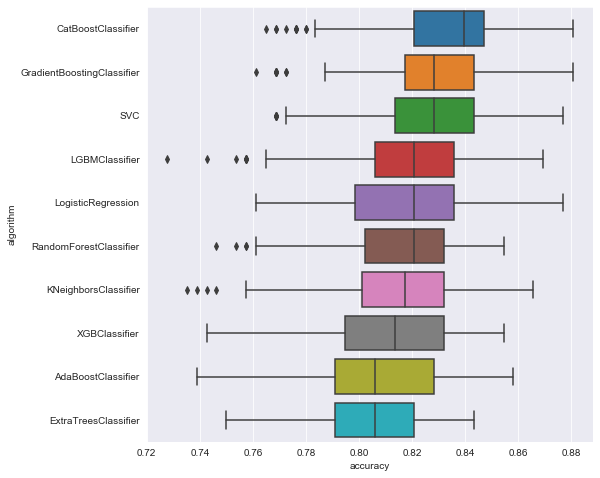

In [504]:
plt.figure(figsize = (8, 8))
order = (comp_table.groupby("algorithm").agg(median = ("accuracy", "median")).
         sort_values("median", ascending = False).reset_index().algorithm)
sns.boxplot(data = comp_table, y = "algorithm", x = "accuracy", order = order)

### In terms of precision also CatBoost and GradientBoosting and SVC classifiers are the best.

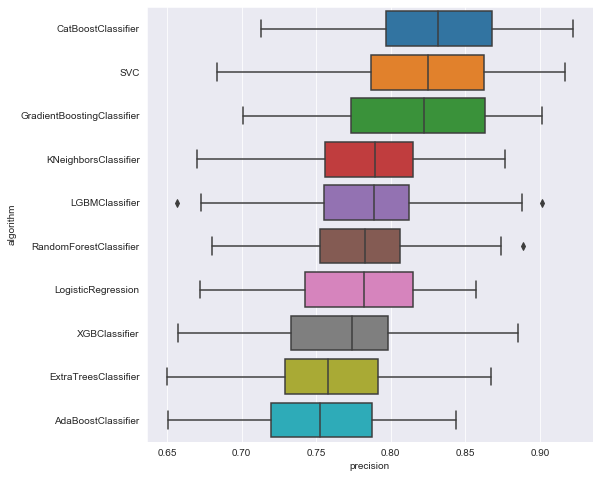

In [505]:
plt.figure(figsize = (8, 8))
order = (comp_table.groupby("algorithm").agg(median = ("precision", "median")).
         sort_values("median", ascending = False).reset_index().algorithm)
sns.boxplot(data = comp_table, y = "algorithm", x = "precision", order = order)

### In terms of recall the best algorithm is AdaBoostClassifier. CatBoost, GradientBoosting and SVC aren't as good as in previous cases. In real case, when human survival will be target variable, the most important metric will be recall. Here I struggle with Kaggle competition where accuracy is taken into account, so accuracy will be my benchmark.

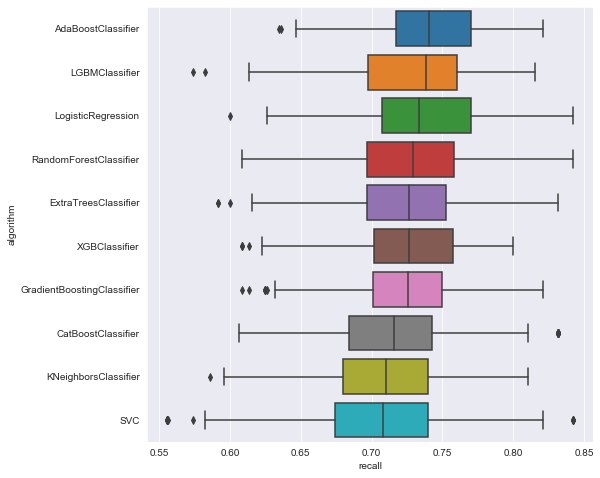

In [507]:
plt.figure(figsize = (8, 8))
order = (comp_table.groupby("algorithm").agg(median = ("recall", "median")).
         sort_values("median", ascending = False).reset_index().algorithm)
sns.boxplot(data = comp_table, y = "algorithm", x = "recall", order = order)

### SimpleImputer with most frequent strategy gives the best results. Boxplos show that considered strategies are similar.

In [508]:
(comp_table.groupby("imputer").agg({"accuracy": ["mean", "median", "std", "min", "max"],
                                     "precision": ["mean", "median", "std", "min", "max"],
                                     "recall": ["mean", "median", "std", "min", "max"]}).
 sort_values(by = ("accuracy", "mean"), ascending = False))

accuracy                                          \
                                 mean    median       std       min       max   
imputer                                                                         
SimpleImputer_most_frequent  0.818828  0.820896  0.024380  0.727612  0.880597   
SimpleImputer_median         0.818646  0.820896  0.024250  0.738806  0.880597   
SimpleImputer_mean           0.818362  0.820896  0.024105  0.742537  0.876866   
SimpleImputer_constant       0.816541  0.817164  0.024593  0.735075  0.876866   

                            precision                                          \
                                 mean    median       std       min       max   
imputer                                                                         
SimpleImputer_most_frequent  0.789963  0.787879  0.051627  0.660194  0.917808   
SimpleImputer_median         0.789704  0.790000  0.051632  0.650000  0.915493   
SimpleImputer_mean           0.789731  0.790123  0.051266  0.657143  0.915493   
SimpleImputer_constant       0.785924  0.784314  0.053167  0.650485  0.922078   

                               recall                                          
                                 mean    median       std       min       max  
imputer                                                                        
SimpleImputer_most_frequent  0.724326  0.727273  0.046655  0.555556  0.842105  
SimpleImputer_median         0.724079  0.727273  0.045601  0.555556  0.842105  
SimpleImputer_mean           0.723061  0.723810  0.045381  0.555556  0.842105  
SimpleImputer_constant       0.723268  0.727273  0.048202  0.555556  0.842105

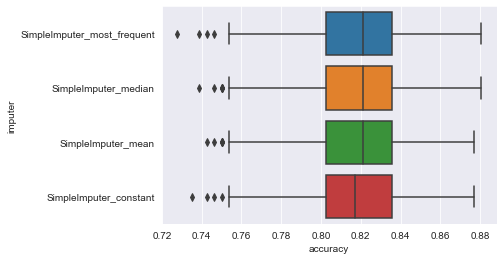

In [509]:
order = (comp_table.groupby("imputer").agg(mean = ("accuracy", "mean")).
         reset_index().sort_values(by = "mean", ascending = False).imputer)
sns.boxplot(data = comp_table, y = "imputer", x = "accuracy", order = order)

### StandardScaler perform the best. He has the biggest mean accuracy and has one of the smallest interquartile range what mean (compare to the other scalers) that is stable.

In [510]:
(comp_table.groupby("scaler").agg({"accuracy": ["mean", "median", "std", "min", "max"],
                                     "precision": ["mean", "median", "std", "min", "max"],
                                     "recall": ["mean", "median", "std", "min", "max"]}).
 sort_values(by = ("accuracy", "mean"), ascending = False))

accuracy                                          \
                         mean    median       std       min       max   
scaler                                                                  
StandardScaler       0.823274  0.824627  0.022950  0.750000  0.880597   
MinMaxScaler         0.822295  0.824627  0.023140  0.750000  0.880597   
MaxAbsScaler         0.822132  0.820896  0.022645  0.750000  0.880597   
QuantileTransformer  0.821828  0.824627  0.022826  0.750000  0.880597   
Normalizer           0.800942  0.800373  0.022357  0.727612  0.865672   

                    precision                                          \
                         mean    median       std       min       max   
scaler                                                                  
StandardScaler       0.795721  0.794118  0.049542  0.650000  0.921053   
MinMaxScaler         0.798146  0.795918  0.052414  0.669903  0.921053   
MaxAbsScaler         0.794305  0.793478  0.048863  0.653846  0.921053   
QuantileTransformer  0.798011  0.795699  0.050675  0.653465  0.922078   
Normalizer           0.757970  0.754902  0.046267  0.650485  0.897727   

                       recall                                          
                         mean    median       std       min       max  
scaler                                                                 
StandardScaler       0.730406  0.731481  0.040952  0.617391  0.842105  
MinMaxScaler         0.724209  0.727273  0.046580  0.555556  0.831579  
MaxAbsScaler         0.728410  0.728972  0.042948  0.582609  0.831579  
QuantileTransformer  0.722747  0.727273  0.047597  0.556522  0.831579  
Normalizer           0.712645  0.711538  0.051529  0.573913  0.842105

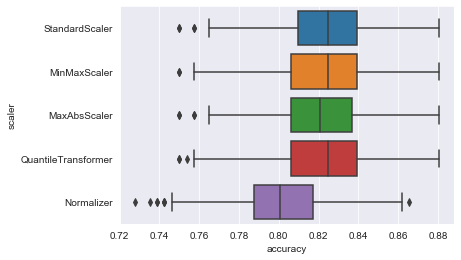

In [512]:
order = (comp_table.groupby("scaler").agg(mean = ("accuracy", "mean")).
         reset_index().sort_values(by = "mean", ascending = False).scaler)
sns.boxplot(data = comp_table, y = "scaler", x = "accuracy", order = order)

### Finally, I present boxplots showing the distribution of the accuracy depending on all considered scalers and imputer strategies.

C:\Users\wlamc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


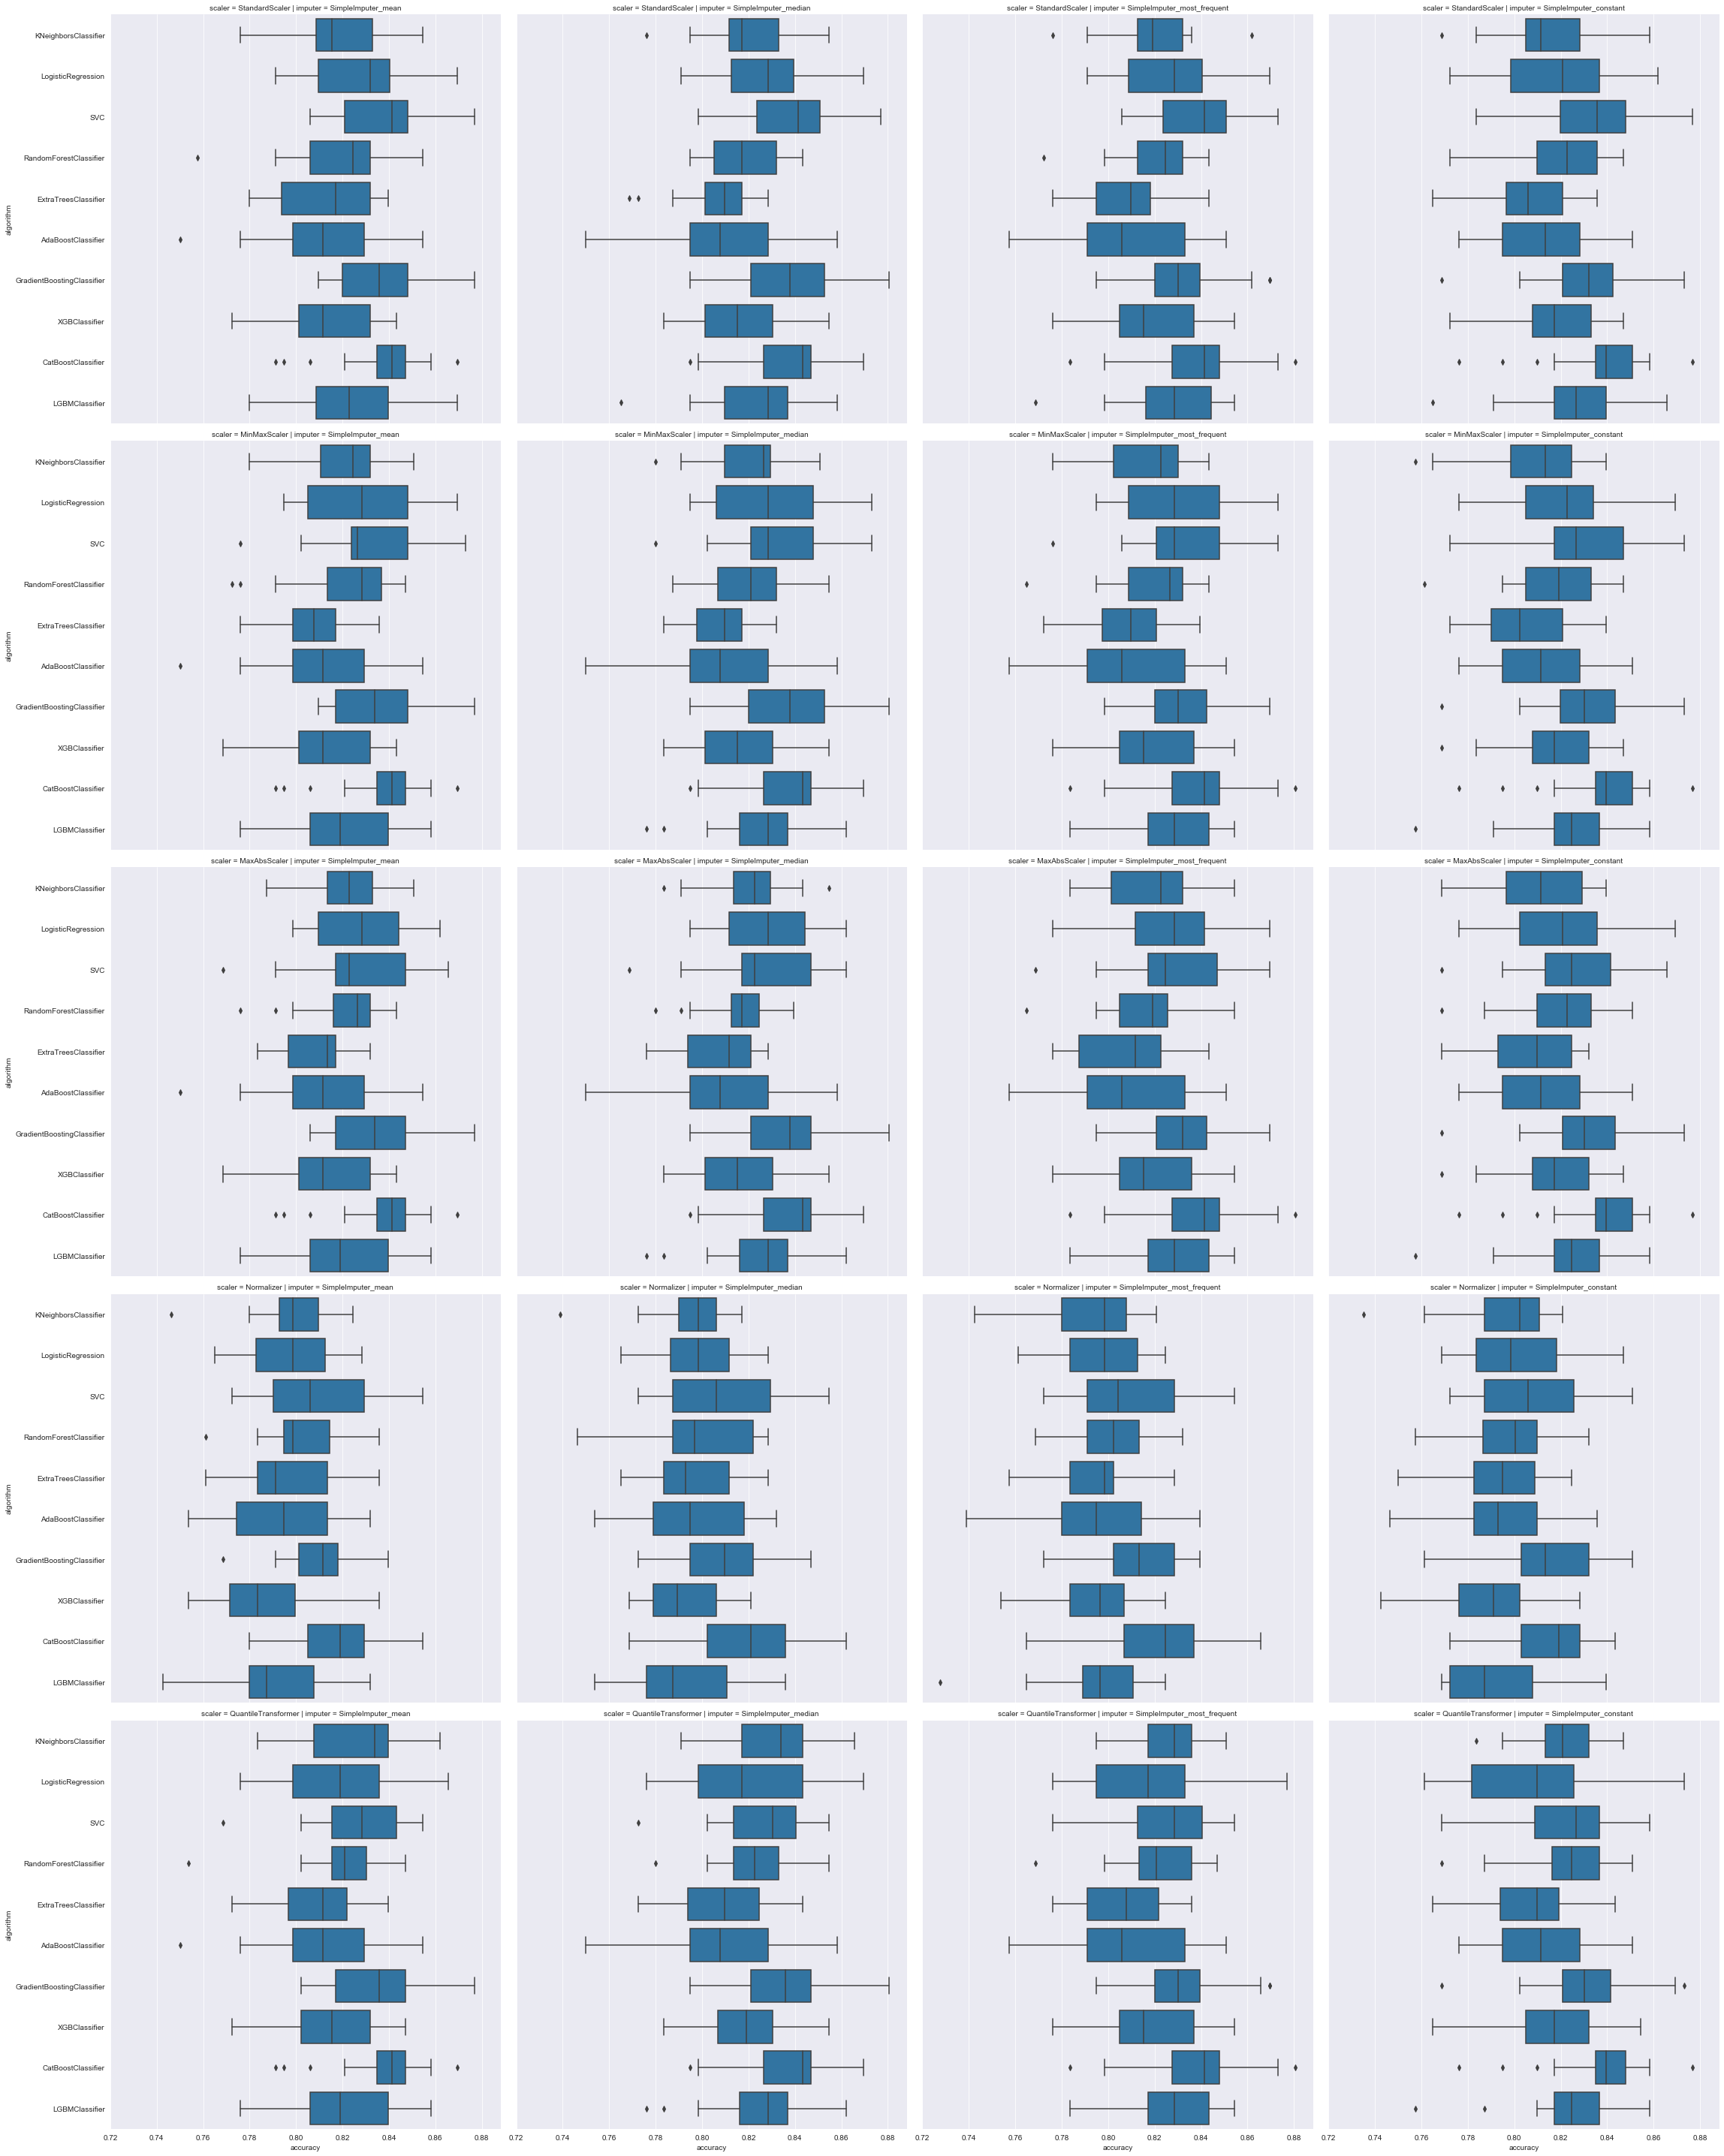

In [524]:
g = sns.FacetGrid(data = comp_table, row = "scaler", col = "imputer", height = 8)
g.map(sns.boxplot, "accuracy", "algorithm")